In [1]:
# To reload external files automatically (ex: utils)
%load_ext autoreload
%autoreload 2

import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle # For rectangles
import proplot as plot # New plot library (https://proplot.readthedocs.io/en/latest/)
from scipy import stats # For linregress (trends)
import xesmf as xe # For regridding (https://xesmf.readthedocs.io/en/latest/)

import sys
sys.path.insert(1, '/home/mlalande/notebooks') # to include my util file in previous directory
import utils as u # my personal functions
u.check_python_version()
u.check_virtual_memory()

ModuleNotFoundError: No module named 'utils'

In [ ]:
path = '/data/mlalande/MODIS/MOD10CM/hdf/'

In [ ]:
ds = xr.open_dataset(path+'MOD10CM.A2000061.006.2016063065826.hdf')
ds

In [4]:
ds.Snow_Cover_Monthly_CMG

<xarray.DataArray 'Snow_Cover_Monthly_CMG' (YDim:MOD_CMG_Snow_5km: 3600, XDim:MOD_CMG_Snow_5km: 7200)>
[25920000 values with dtype=float32]
Dimensions without coordinates: YDim:MOD_CMG_Snow_5km, XDim:MOD_CMG_Snow_5km
Attributes:
    long_name:             Monthly snow cover extent, 5km
    units:                 none
    format:                I3
    coordsys:              latitude, longitude
    valid_range:           [  0 100]
    Mask_value:            254
    Night_value:           211
    Cell_resolution:       0.05 deg
    Antarctica_snow_note:  Antarctica deliberately mapped as snow
    Key:                   0-100=percent of snow in cell, 211=night, 250=clou...

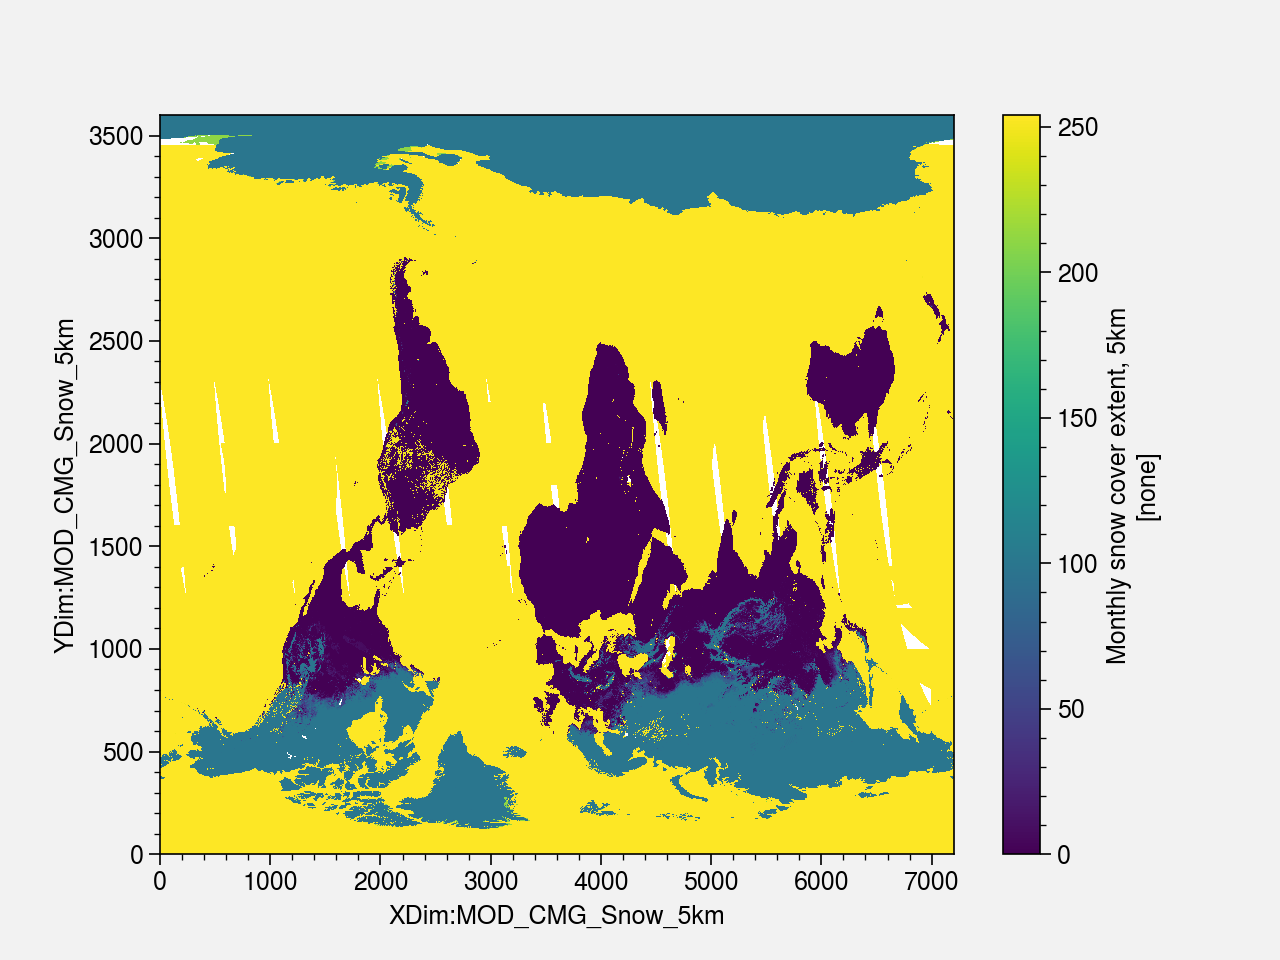

In [5]:
ds.Snow_Cover_Monthly_CMG.plot()

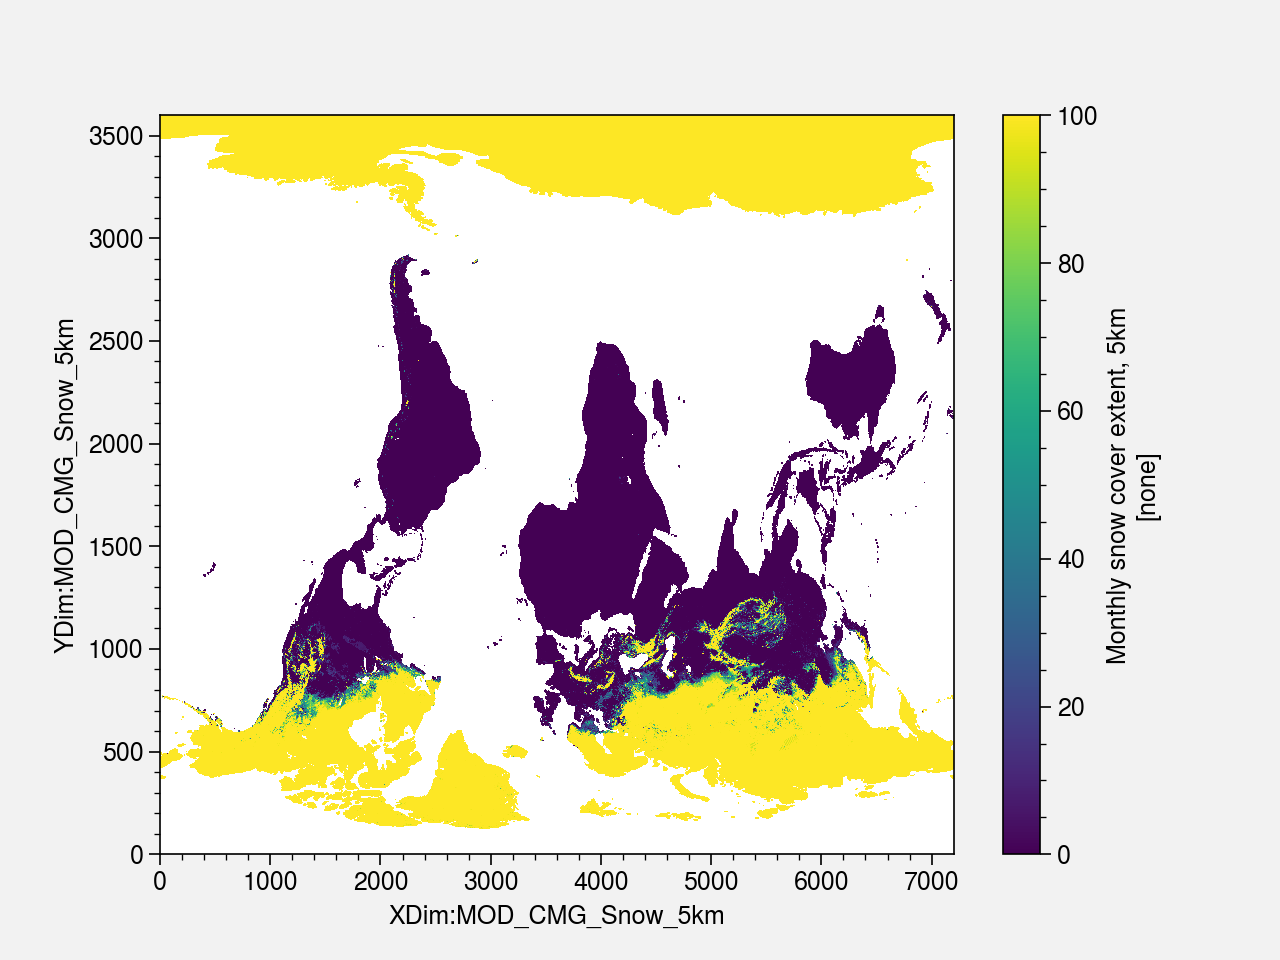

In [6]:
ds.Snow_Cover_Monthly_CMG.where(ds.Snow_Cover_Monthly_CMG <= 100).plot()

# Create coordinates

https://nsidc.org/data/MOD10CM

Grid
The MODIS CMG consists of 7200 columns by 3600 rows. Each cell has a resolution of **0.05 degrees** (approximately 5 km). The upper-left corner of the upper-left cell is -180.00 degrees longitude, 90.00 degrees latitude. The lower-right corner of the lower right cell is -180.00 degrees longitude, -90.00 degrees latitude. For additional details about the MODIS Climate Modeling Grid, see the NASA MODIS Lands | MODIS Grids Web page.

The following resources can help you select and work with gridded MODIS data:

HDF-EOS to GeoTIFF Conversion Tool (HEG)

Other products: https://modis.gsfc.nasa.gov/data/dataprod/mod10.php  
More info on grids: https://modis-land.gsfc.nasa.gov/MODLAND_grid.html

## Use xESMF
https://xesmf.readthedocs.io/en/latest/notebooks/Curvilinear_grid.html#Output-grid

In [4]:
grid = xe.util.grid_global(d_lon=0.05, d_lat=0.05)
grid

/data/mlalande/miniconda3/envs/work/lib/python3.8/site-packages/xesmf/util.py:91: UserWarning: 360 cannot be divided by d_lon = 0.05, might not cover the globe uniformally
  warnings.warn('360 cannot be divided by d_lon = {}, '
/data/mlalande/miniconda3/envs/work/lib/python3.8/site-packages/xesmf/util.py:95: UserWarning: 180 cannot be divided by d_lat = 0.05, might not cover the globe uniformally
  warnings.warn('180 cannot be divided by d_lat = {}, '


<xarray.Dataset>
Dimensions:  (x: 7200, x_b: 7201, y: 3600, y_b: 3601)
Coordinates:
    lon      (y, x) float64 -180.0 -179.9 -179.9 -179.8 ... 179.9 179.9 180.0
    lat      (y, x) float64 -89.97 -89.97 -89.97 -89.97 ... 89.97 89.97 89.97
    lon_b    (y_b, x_b) float64 -180.0 -179.9 -179.9 ... 179.9 180.0 180.0
    lat_b    (y_b, x_b) float64 -90.0 -90.0 -90.0 -90.0 ... 90.0 90.0 90.0 90.0
Dimensions without coordinates: x, x_b, y, y_b
Data variables:
    *empty*

In [5]:
grid.lon[0].values

array([-179.975, -179.925, -179.875, ...,  179.875,  179.925,  179.975])

In [6]:
np.flip(grid.lat[:,0].values)

array([ 89.975,  89.925,  89.875, ..., -89.875, -89.925, -89.975])

In [5]:
ds = ds.rename({"XDim:MOD_CMG_Snow_5km": "lon", "YDim:MOD_CMG_Snow_5km": "lat"})
ds = ds.assign_coords({"lon": grid.lon[0].values, "lat": np.flip(grid.lat[:,0].values)})
ds

<xarray.Dataset>
Dimensions:                 (lat: 3600, lon: 7200)
Coordinates:
  * lon                     (lon) float64 -180.0 -179.9 -179.9 ... 179.9 180.0
  * lat                     (lat) float64 89.97 89.92 89.87 ... -89.93 -89.97
Data variables:
    Snow_Cover_Monthly_CMG  (lat, lon) float32 ...
    Snow_Spatial_QA         (lat, lon) float32 ...
Attributes:
    HDFEOSVersion:                     HDFEOS_V2.17
    StructMetadata.0:                  GROUP=SwathStructure\nEND_GROUP=SwathS...
    identifier_product_doi:            10.5067/MODIS/MOD10CM.006
    identifier_product_doi_authority:  http://dx.doi.org
    InputFileNames:                    MOD10C1.A2000061.006.2016062172940.hdf...
    CoreMetadata.0:                    \nGROUP                  = INVENTORYME...
    ArchiveMetadata.0:                 \nGROUP                  = ARCHIVEDMET...

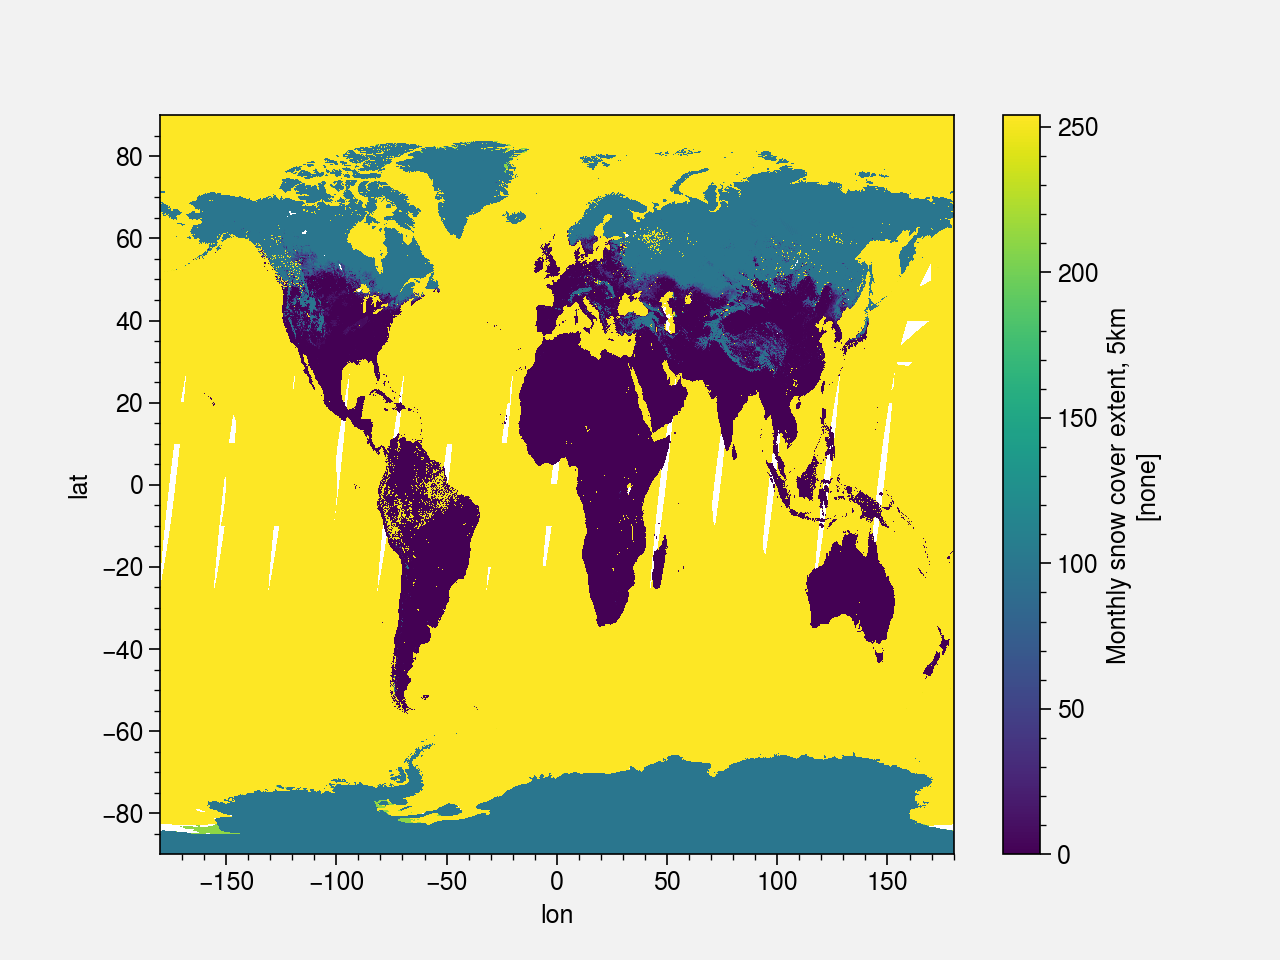

In [32]:
ds.Snow_Cover_Monthly_CMG.plot()

# Check xml file to get the date

In [6]:
import xml.etree.ElementTree as ET
tree = ET.parse(path+'MOD10CM.A2000061.006.2016063065826.hdf.xml')
root = tree.getroot()

for RangeBeginningDate in root.iter('RangeBeginningDate'):
    start = np.datetime64(RangeBeginningDate.text)
    
for RangeEndingDate in root.iter('RangeEndingDate'):
    end = np.datetime64(RangeEndingDate.text)

ds = ds.assign_coords(time=(end - start)/2 + start).expand_dims('time')
ds

<xarray.Dataset>
Dimensions:                 (lat: 3600, lon: 7200, time: 1)
Coordinates:
  * lon                     (lon) float64 -180.0 -179.9 -179.9 ... 179.9 180.0
  * lat                     (lat) float64 89.97 89.92 89.87 ... -89.93 -89.97
  * time                    (time) datetime64[ns] 2000-03-16
Data variables:
    Snow_Cover_Monthly_CMG  (time, lat, lon) float32 nan nan nan ... 100.0 100.0
    Snow_Spatial_QA         (time, lat, lon) float32 1.0 1.0 1.0 ... 252.0 252.0
Attributes:
    HDFEOSVersion:                     HDFEOS_V2.17
    StructMetadata.0:                  GROUP=SwathStructure\nEND_GROUP=SwathS...
    identifier_product_doi:            10.5067/MODIS/MOD10CM.006
    identifier_product_doi_authority:  http://dx.doi.org
    InputFileNames:                    MOD10C1.A2000061.006.2016062172940.hdf...
    CoreMetadata.0:                    \nGROUP                  = INVENTORYME...
    ArchiveMetadata.0:                 \nGROUP                  = ARCHIVEDMET...

# Get only the values [0,100]

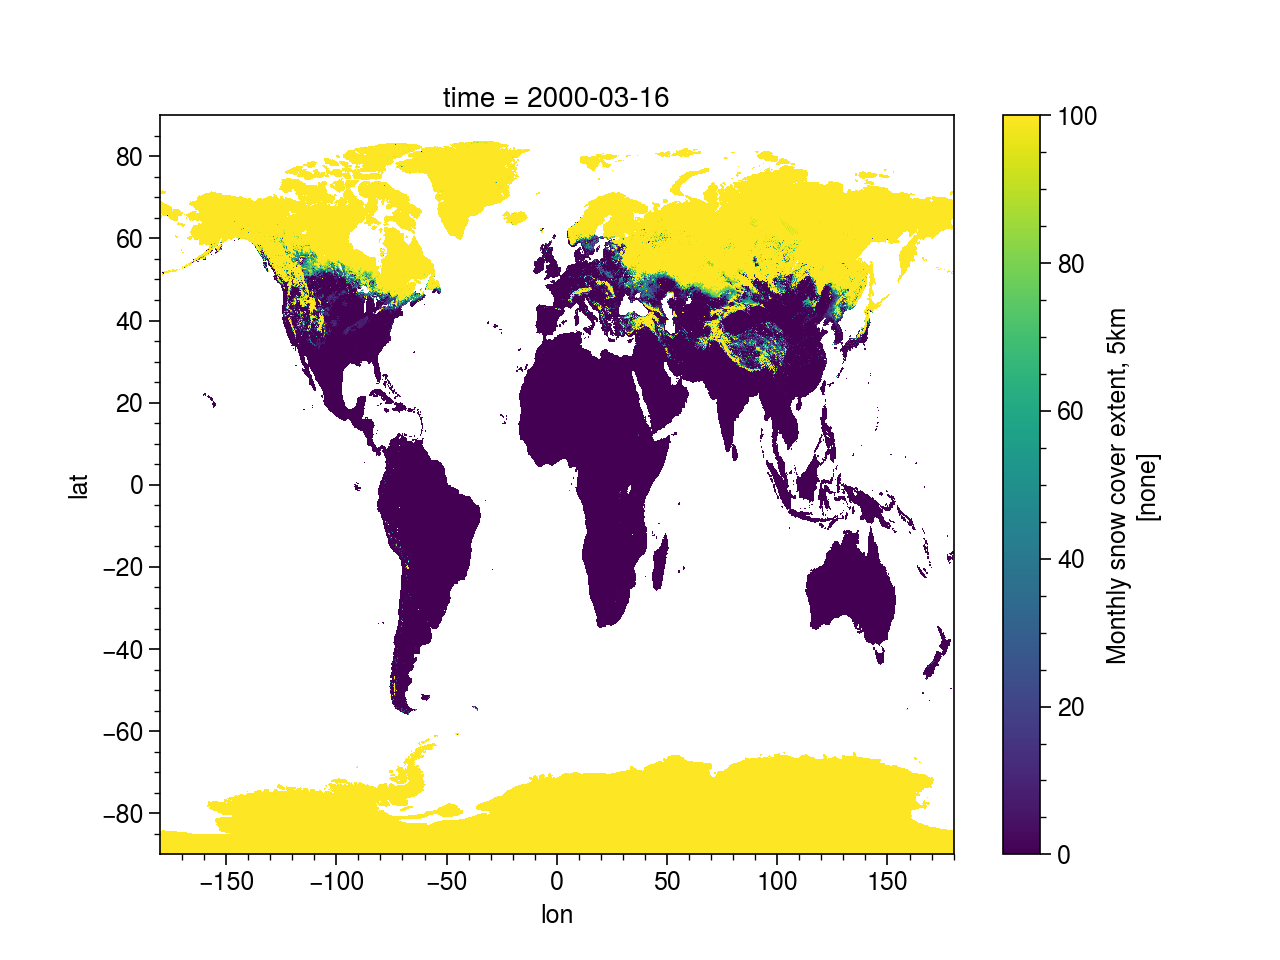

In [20]:
ds.Snow_Cover_Monthly_CMG.where(ds.Snow_Cover_Monthly_CMG <= 100).plot()

In [18]:
ds_out_curv = xe.util.grid_global(0.5, 0.5)
ds_out_curv

<xarray.Dataset>
Dimensions:  (x: 720, x_b: 721, y: 360, y_b: 361)
Coordinates:
    lon      (y, x) float64 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
    lat      (y, x) float64 -89.75 -89.75 -89.75 -89.75 ... 89.75 89.75 89.75
    lon_b    (y_b, x_b) float64 -180.0 -179.5 -179.0 ... 179.0 179.5 180.0
    lat_b    (y_b, x_b) float64 -90.0 -90.0 -90.0 -90.0 ... 90.0 90.0 90.0 90.0
Dimensions without coordinates: x, x_b, y, y_b
Data variables:
    *empty*

In [22]:
ds_out = xr.Dataset({'lat': (['lat'], ds_out_curv.lat[:,0]),
                     'lon': (['lon'], ds_out_curv.lon[0].values)})
ds_out

<xarray.Dataset>
Dimensions:  (lat: 360, lon: 720)
Coordinates:
  * lat      (lat) float64 -89.75 -89.25 -88.75 -88.25 ... 88.75 89.25 89.75
  * lon      (lon) float64 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
Data variables:
    *empty*

In [23]:
regridder = xe.Regridder(ds, ds_out, 'bilinear', periodic=True, reuse_weights=True)

Overwrite existing file: bilinear_3600x7200_360x720_peri.nc 
 You can set reuse_weights=True to save computing time.


In [24]:
snc_regrid = regridder(ds.Snow_Cover_Monthly_CMG.where(ds.Snow_Cover_Monthly_CMG <= 100))
snc_regrid

<xarray.DataArray 'Snow_Cover_Monthly_CMG' (time: 1, lat: 360, lon: 720)>
array([[[100., 100., 100., ..., 100., 100., 100.],
        [100., 100., 100., ..., 100., 100., 100.],
        [100., 100., 100., ..., 100., 100., 100.],
        ...,
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan]]])
Coordinates:
  * time     (time) datetime64[ns] 2000-03-16
  * lon      (lon) float64 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
  * lat      (lat) float64 -89.75 -89.25 -88.75 -88.25 ... 88.75 89.25 89.75
Attributes:
    regrid_method:  bilinear

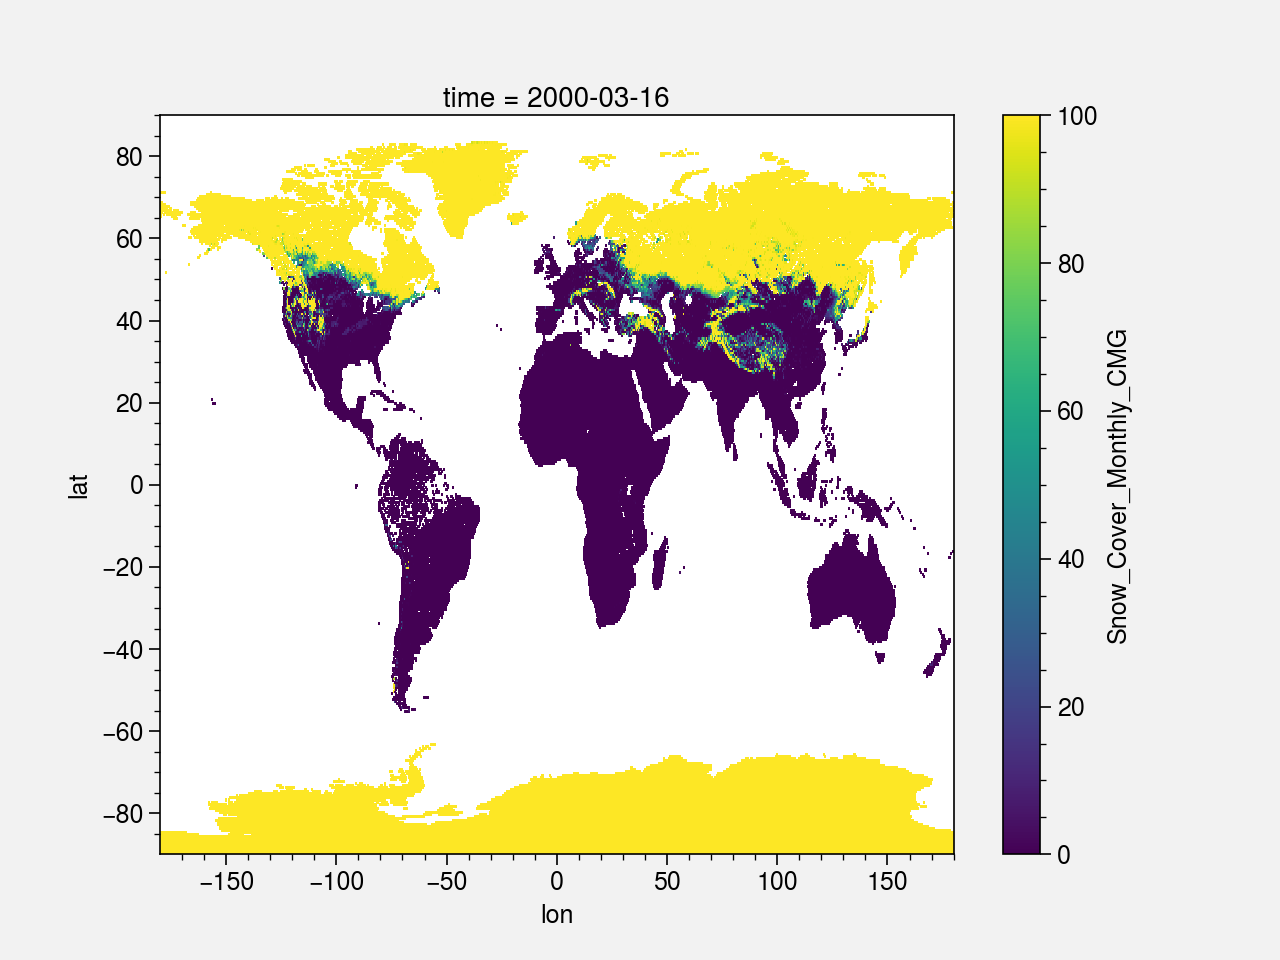

In [26]:
snc_regrid.plot()

In [29]:
ds.Snow_Cover_Monthly_CMG.where(ds.Snow_Cover_Monthly_CMG <= 100)[0].sel(lat=slice(latlim[1],latlim[0]), lon=slice(lonlim[0],lonlim[1]))

<xarray.DataArray 'Snow_Cover_Monthly_CMG' (lat: 800, lon: 1000)>
array([[100., 100., 100., ..., 100., 100., 100.],
       [100., 100., 100., ..., 100., 100., 100.],
       [100., 100., 100., ..., 100., 100., 100.],
       ...,
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan]], dtype=float32)
Coordinates:
  * lon      (lon) float64 60.03 60.08 60.13 60.18 ... 109.8 109.9 109.9 110.0
  * lat      (lat) float64 49.97 49.92 49.87 49.82 ... 10.17 10.12 10.07 10.02
    time     datetime64[ns] 2000-03-16
Attributes:
    long_name:             Monthly snow cover extent, 5km
    units:                 none
    format:                I3
    coordsys:              latitude, longitude
    valid_range:           [  0 100]
    Mask_value:            254
    Night_value:           211
    Cell_resolution:       0.05 deg
    Antarctica_snow_note:  Antarctica deliberately mapped as snow
    Key:                   0-100=percent of snow in cell, 211=night, 250=clou...

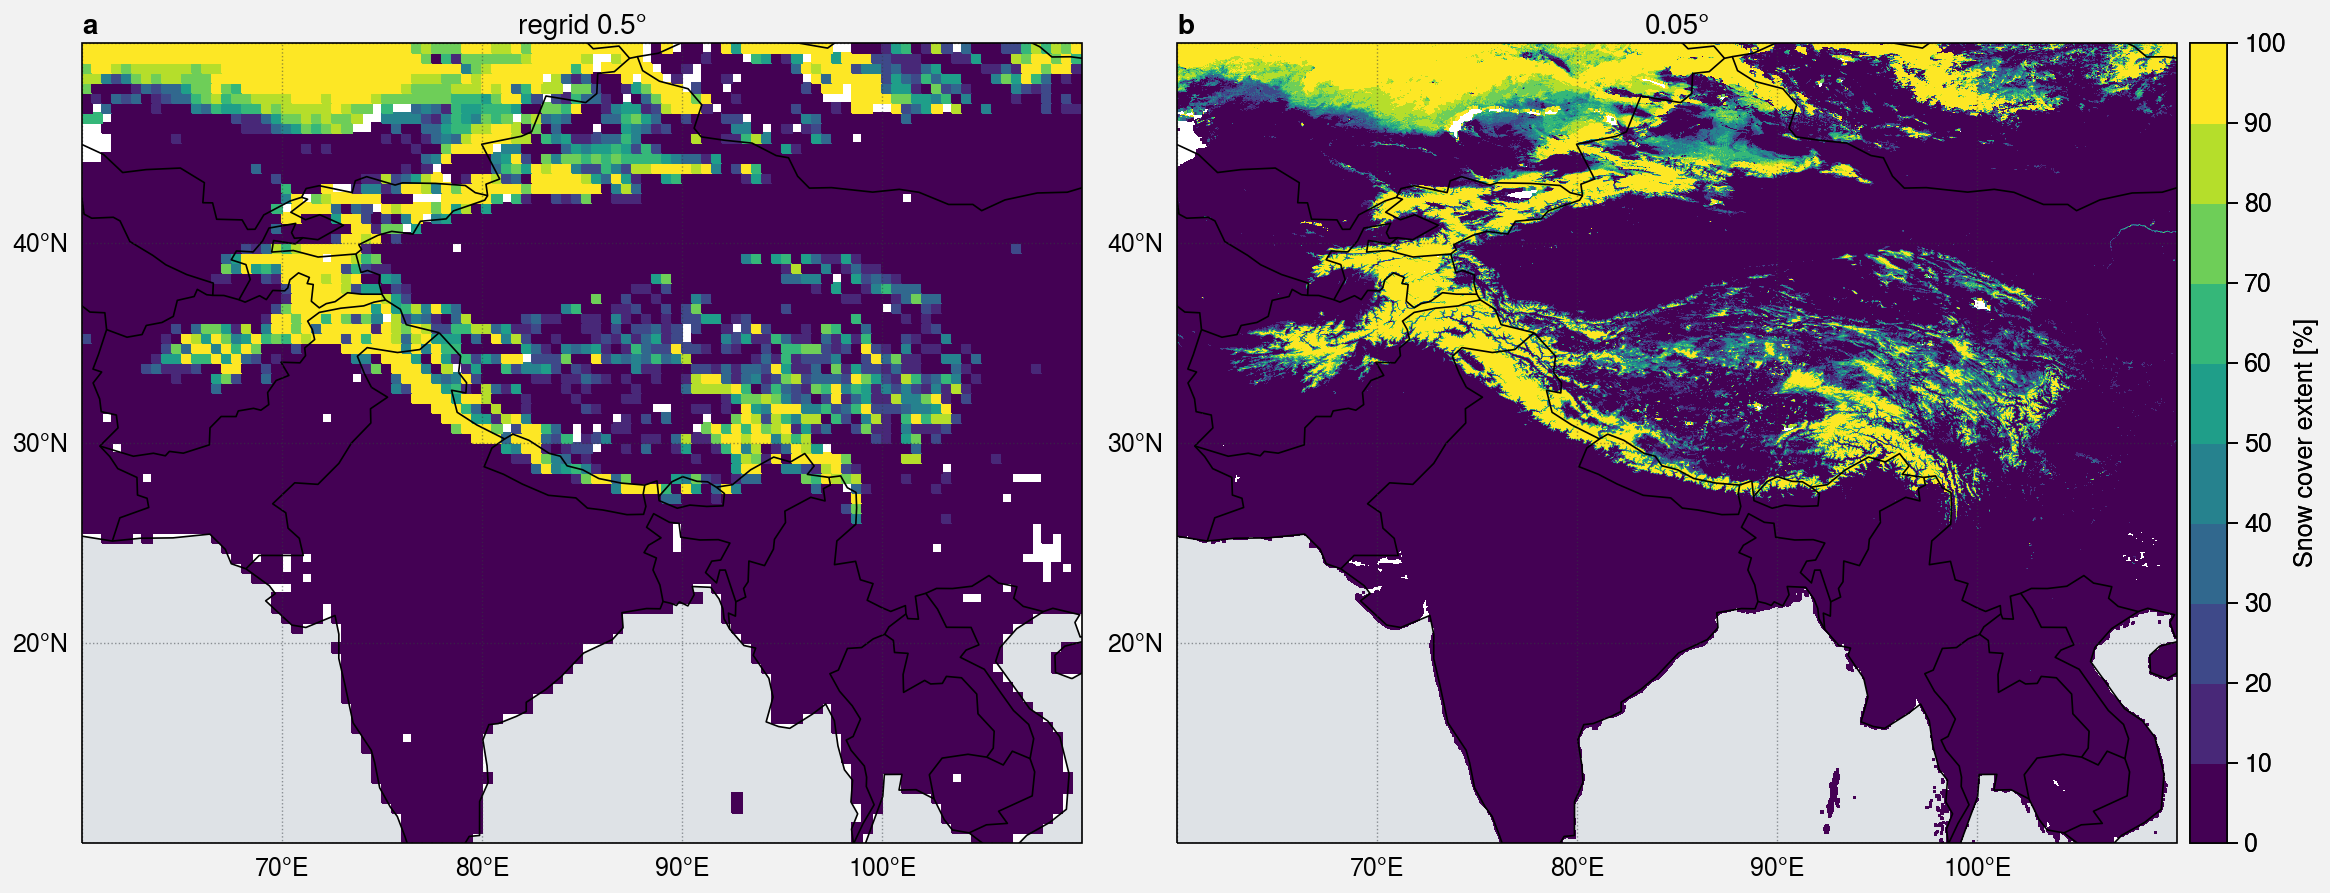

In [32]:
latlim=(10,50)
lonlim=(60,110)

var = 'snc'
label = 'Snow cover extent'
units = '%'
cmap='viridis'
levels=plot.arange(0,100,10)

f, axs = plot.subplots(proj='cyl', ncols=2, nrows=1, axwidth=5)

axs[0].pcolormesh(snc_regrid[0].sel(lat=slice(latlim[0],latlim[1]), lon=slice(lonlim[0],lonlim[1])), cmap=cmap, levels=levels)
axs[0].format(title='regrid 0.5°')

m1 = axs[1].pcolormesh(ds.Snow_Cover_Monthly_CMG.where(ds.Snow_Cover_Monthly_CMG <= 100)[0].sel(lat=slice(latlim[1],latlim[0]), lon=slice(lonlim[0],lonlim[1])), cmap=cmap, levels=levels)
axs[1].format(title='0.05°')
axs[1].colorbar(m1, label=label+ ' ['+units+']')


axs.format(
    geogridlinewidth=0.5, geogridcolor='gray8', geogridalpha=0.5, labels=True, 
    coast=True, ocean=True, oceancolor='gray3', borders=True,
#     suptitle=label+" annual climatology: "+period.start+"-"+period.stop,
    lonlines=10, latlines=10, abc=True, latlim=latlim, lonlim=lonlim
)

In [34]:
ds.Snow_Cover_Monthly_CMG.Key

'0-100=percent of snow in cell, 211=night, 250=cloud, 253=no decision, 254=water mask, 255=fill'

Still some missing values, don't know exactly what it is... I'll try with this hoping that the climatologies will hide this values?